<a href="https://colab.research.google.com/github/rex1314/momentum/blob/main/Stock_BRC_trade.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
def test_example():
    assert 1 + 1 == 2

In [ ]:
pip install pandas matplotlib numpy yfinance


In [ ]:
raw_data.to_csv("/content/BTCUSDT_1hr_data_record_v3.csv")

final

[*********************100%***********************]  1 of 1 completed


Total Trades: 171
Wins: 100
Losses: 71
Win Rate: 58.48%
Average Gain: 29.25
Average Loss: -16.41
Total Profit/Loss: 1759.94
Date: 2023-01-24 18:00:00+00:00, Entry: 23001.6796875, Exit: 22825.888671875, Result: loss
Date: 2023-01-28 15:00:00+00:00, Entry: 23033.318359375, Exit: 23157.791015625, Result: win
Date: 2023-02-01 13:00:00+00:00, Entry: 23104.650390625, Exit: 23248.845703125, Result: win
Date: 2023-02-19 19:00:00+00:00, Entry: 24549.453125, Exit: 24392.875, Result: loss
Date: 2023-02-19 21:00:00+00:00, Entry: 24542.796875, Exit: 24371.728515625, Result: loss
Date: 2023-02-20 04:00:00+00:00, Entry: 24508.47265625, Exit: 24820.59765625, Result: win
Date: 2023-02-21 18:00:00+00:00, Entry: 24698.94921875, Exit: 24413.107421875, Result: loss
Date: 2023-03-15 18:00:00+00:00, Entry: 24433.994140625, Exit: 24903.078125, Result: win
Date: 2023-03-15 21:00:00+00:00, Entry: 24524.033203125, Exit: 24814.412109375, Result: win
Date: 2023-03-19 00:00:00+00:00, Entry: 27138.80078125, Exit: 27

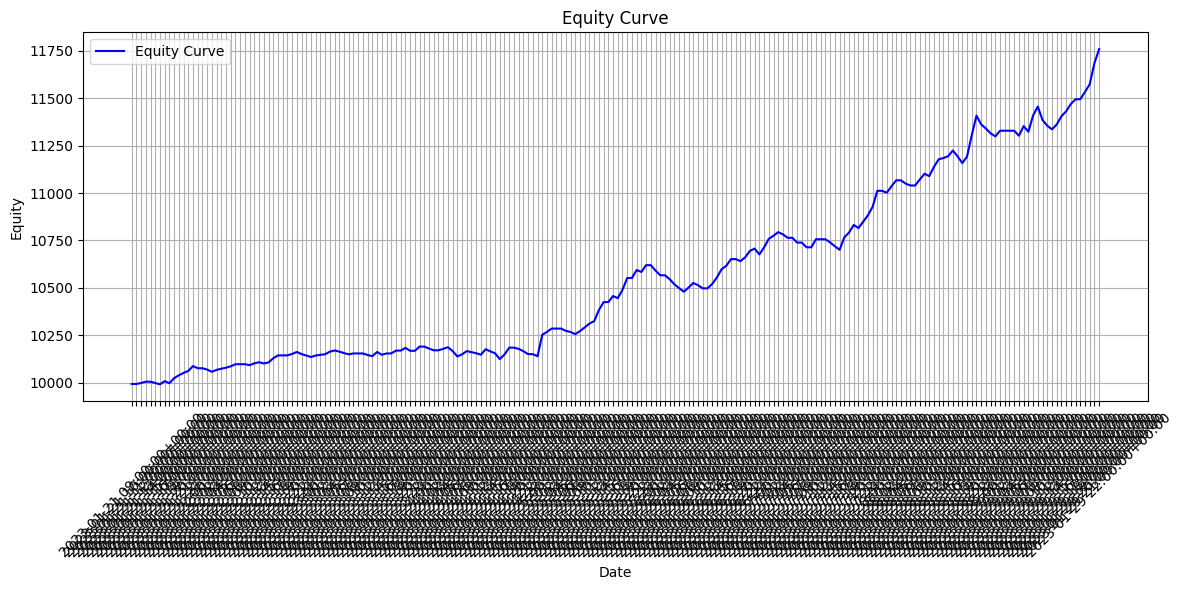

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt


import yfinance as yf
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta


# Define the ticker symbol
ticker_symbol = "BTC-USD"

# Get the data for the ticker
data = yf.download(ticker_symbol, interval="1h")

# Save the data to a CSV file
data.to_csv("/content/BTCUSDT_1hr_data.csv")

# Read the CSV file into a DataFrame
raw_data = pd.read_csv("/content/BTCUSDT_1hr_data.csv")

# Ensure that the 'Close', 'High', and 'Low' columns are of numeric type
raw_data['Close'] = pd.to_numeric(raw_data['Close'], errors='coerce')
raw_data['High'] = pd.to_numeric(raw_data['High'], errors='coerce')
raw_data['Low'] = pd.to_numeric(raw_data['Low'], errors='coerce')

# Calculate the 50 EMA and 200 EMA
raw_data['50 EMA'] = raw_data['Close'].ewm(span=50, adjust=False).mean()
raw_data['200 EMA'] = raw_data['Close'].ewm(span=200, adjust=False).mean()

# Calculate Bollinger Bands (20)
raw_data['20 SMA'] = raw_data['Close'].rolling(window=20).mean()
raw_data['20 StdDev'] = raw_data['Close'].rolling(window=20).std()
raw_data['Upper Band'] = raw_data['20 SMA'] + (raw_data['20 StdDev'] * 2)
raw_data['Lower Band'] = raw_data['20 SMA'] - (raw_data['20 StdDev'] * 2)

# Add three more columns
# 1) Low hit lower band (=IF(Low<lower band,1,0))
raw_data['Low hit lower band'] = (raw_data['Low'] < raw_data['Lower Band']).astype(int)

# 2) Close price over ema 50_200 (=IF(AND(Close>EMA50,Close>EMA200),1,0))
raw_data['Close price over ema 50_200'] = ((raw_data['Close'] > raw_data['50 EMA']) & (raw_data['Close'] > raw_data['200 EMA'])).astype(int)

# 3) If low hit lower band, store the high price (=IF(Low hit lower band =1, High,0))
raw_data['High if low hit lower band'] = raw_data.apply(lambda row: int(row['High']) if row['Low hit lower band'] == 1 else 0, axis=1)

# 4) If low hit lower band, store the high price (=IF(Low hit lower band =1, High,0))
raw_data['Low if low hit lower band'] = raw_data.apply(lambda row: float(row['Low']) if row['Low hit lower band'] == 1 else 0, axis=1)

# Check if close price exceeds the stored high within 5 candlesticks and enter long position
raw_data['Enter Long'] = 0
for i in range(len(raw_data) - 5):
    if raw_data.loc[i, 'High if low hit lower band'] > 0:
        for j in range(1, 6):
            if raw_data.loc[i + j, 'Close'] > raw_data.loc[i, 'High if low hit lower band']:
                raw_data.loc[i + j, 'Enter Long'] = 1
                break

# Add a column to store the close price when "Enter Long" = 1
raw_data['Close when Enter Long'] = raw_data.apply(lambda row: row['Close'] if row['Enter Long'] == 1 else 0, axis=1)

# Remove row 0 and row 1 from the DataFrame
raw_data.drop([0, 1], inplace=True)
raw_data.rename(columns={'Price': 'Date'}, inplace=True)
#raw_data.sort_values(by='Date', ascending=False, inplace=True)

# Add the "Low hit indicator" column
raw_data['Low hit indicator'] = (raw_data['Low if low hit lower band'] > 0).astype(int)

# Add a column to find the previous value in "Low hit indicator" and search the price in "High if low hit lower band"
def find_previous_high(row):
    if row.name == 0:
        return None
    previous_row_index = row.name - 1
    while previous_row_index >= 0:
        if raw_data.loc[previous_row_index, 'Low hit indicator'] == 1:
            return raw_data.loc[previous_row_index, 'Low if low hit lower band']
        previous_row_index -= 1
    return None

raw_data['Previous Low if Low Hit Indicator'] = raw_data.apply(lambda row: find_previous_high(row) if row['Enter Long'] == 1 else None, axis=1)

raw_data['Potential_Loss'] = (raw_data['Close when Enter Long']-raw_data['Previous Low if Low Hit Indicator']).astype(float)
raw_data['Potential_Gain'] = (raw_data['Close when Enter Long']+raw_data['Potential_Loss']).astype(float)

trades = []
results = []
equity_curve = []

# Starting equity
initial_equity = 10000  # Example starting equity
current_equity = initial_equity

# Fixed position size and transaction cost
position_size = 0.03  # BTC
transaction_cost = 1.99  # USD

# Iterate through the DataFrame to evaluate trades
for index, row in raw_data.iterrows():
    if row['Enter Long'] == 1 and row['Close price over ema 50_200'] ==1 and row['Potential_Loss'] < 2500.0:
        entry_price = row['Close when Enter Long']
        stop_loss = row['Previous Low if Low Hit Indicator']
        take_profit = row['Potential_Gain']
        trade_date = row['Date']  # Capture the transaction date

        # Check if stop loss or take profit was hit in the next rows
        for future_index in range(index + 1, min(index + 30, len(raw_data))):
            future_row = raw_data.iloc[future_index]
            if future_row['Close'] <= stop_loss:
                # Stop loss hit
                trades.append({'entry_price': entry_price, 'exit_price': stop_loss, 'result': 'loss', 'date': trade_date})
                result = (stop_loss - entry_price) * position_size - transaction_cost  # Adjust for transaction cost
                results.append(result)
                current_equity += result  # Update current equity
                equity_curve.append(current_equity)
                break
            elif future_row['Close'] >= take_profit:
                # Take profit hit
                trades.append({'entry_price': entry_price, 'exit_price': take_profit, 'result': 'win', 'date': trade_date})
                result = (take_profit - entry_price)*2 * position_size - transaction_cost  # Adjust for transaction cost
                results.append(result)
                current_equity += result  # Update current equity
                equity_curve.append(current_equity)
                break
        else:
            # If neither stop loss nor take profit hit, carry forward the current equity
            equity_curve.append(current_equity)

# Calculate performance metrics
total_trades = len(trades)
wins = len([trade for trade in trades if trade['result'] == 'win'])
losses = len([trade for trade in trades if trade['result'] == 'loss'])
win_rate = (wins / total_trades * 100) if total_trades > 0 else 0

# Calculate average gain and average loss
average_gain = sum(result for result in results if result > 0) / wins if wins > 0 else 0
average_loss = sum(result for result in results if result < 0) / losses if losses > 0 else 0

# Print the results
print(f"Total Trades: {total_trades}")
print(f"Wins: {wins}")
print(f"Losses: {losses}")
print(f"Win Rate: {win_rate:.2f}%")
print(f"Average Gain: {average_gain:.2f}")
print(f"Average Loss: {average_loss:.2f}")
print(f"Total Profit/Loss: {sum(results):.2f}")

# Print trades with transaction dates
for trade in trades:
    print(f"Date: {trade['date']}, Entry: {trade['entry_price']}, Exit: {trade['exit_price']}, Result: {trade['result']}")

# Plotting the equity curve
plt.figure(figsize=(12, 6))
plt.plot(raw_data['Date'].iloc[:len(equity_curve)], equity_curve, label='Equity Curve', color='blue')
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Equity')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [2]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

# Function to send a message via Telegram bot
def send_telegram_message(token, chat_id, message):
    url = f"https://api.telegram.org/bot{token}/sendMessage"
    data = {
        "chat_id": chat_id,
        "text": message
    }
    response = requests.post(url, data=data)
    return response.json()

telegram_token = '7643335075:AAGl3dHfBvbyatHkaXHIQlYKNgCtc3OHNQU'
telegram_chat_id = '8001172561'

# Define the ticker symbol
ticker_symbol = "BTC-USD"

# Get the data for the ticker
data = yf.download(ticker_symbol, interval="1h")

# Save the data to a CSV file
data.to_csv("/content/BTCUSDT_1hr_data.csv")

# Read the CSV file into a DataFrame
raw_data = pd.read_csv("/content/BTCUSDT_1hr_data.csv")

# Ensure that the 'Close', 'High', and 'Low' columns are of numeric type
raw_data['Close'] = pd.to_numeric(raw_data['Close'], errors='coerce')
raw_data['High'] = pd.to_numeric(raw_data['High'], errors='coerce')
raw_data['Low'] = pd.to_numeric(raw_data['Low'], errors='coerce')

# Calculate the 50 EMA and 200 EMA
raw_data['50 EMA'] = raw_data['Close'].ewm(span=50, adjust=False).mean()
raw_data['200 EMA'] = raw_data['Close'].ewm(span=200, adjust=False).mean()

# Calculate Bollinger Bands (20)
raw_data['20 SMA'] = raw_data['Close'].rolling(window=20).mean()
raw_data['20 StdDev'] = raw_data['Close'].rolling(window=20).std()
raw_data['Upper Band'] = raw_data['20 SMA'] + (raw_data['20 StdDev'] * 2)
raw_data['Lower Band'] = raw_data['20 SMA'] - (raw_data['20 StdDev'] * 2)

# Add three more columns
raw_data['Low hit lower band'] = (raw_data['Low'] < raw_data['Lower Band']).astype(int)
raw_data['Close price over ema 50_200'] = ((raw_data['Close'] > raw_data['50 EMA']) & (raw_data['Close'] > raw_data['200 EMA'])).astype(int)
raw_data['High if low hit lower band'] = raw_data.apply(lambda row: int(row['High']) if row['Low hit lower band'] == 1 else 0, axis=1)
raw_data['Low if low hit lower band'] = raw_data.apply(lambda row: float(row['Low']) if row['Low hit lower band'] == 1 else 0, axis=1)

# Check if close price exceeds the stored high within 5 candlesticks and enter long position
raw_data['Enter Long'] = 0
for i in range(len(raw_data) - 5):
    if raw_data.loc[i, 'High if low hit lower band'] > 0:
        for j in range(1, 6):
            if raw_data.loc[i + j, 'Close'] > raw_data.loc[i, 'High if low hit lower band']:
                raw_data.loc[i + j, 'Enter Long'] = 1
                break

raw_data['Close when Enter Long'] = raw_data.apply(lambda row: row['Close'] if row['Enter Long'] == 1 else 0, axis=1)
raw_data.drop([0, 1], inplace=True)
raw_data.rename(columns={'Price': 'Date'}, inplace=True)
raw_data['Low hit indicator'] = (raw_data['Low if low hit lower band'] > 0).astype(int)

def find_previous_high(row):
    if row.name == 0:
        return None
    previous_row_index = row.name - 1
    while previous_row_index >= 0:
        if raw_data.loc[previous_row_index, 'Low hit indicator'] == 1:
            return raw_data.loc[previous_row_index, 'Low if low hit lower band']
        previous_row_index -= 1
    return None

raw_data['Previous Low if Low Hit Indicator'] = raw_data.apply(lambda row: find_previous_high(row) if row['Enter Long'] == 1 else None, axis=1)
raw_data['Potential_Loss'] = (raw_data['Close when Enter Long'] - raw_data['Previous Low if Low Hit Indicator']).astype(float)
raw_data['Potential_Gain'] = (raw_data['Close when Enter Long'] + raw_data['Potential_Loss']).astype(float)


# Variable to store the last trade message
last_trade_message = ""

# Iterate through the DataFrame to evaluate trades
for index, row in raw_data.iterrows():
    if row['Enter Long'] == 1 and row['Close price over ema 50_200'] == 1 and row['Potential_Loss'] < 2500.0:
        entry_price = row['Close when Enter Long']
        stop_loss = row['Previous Low if Low Hit Indicator']
        take_profit = row['Potential_Gain']
        trade_date = row['Date']  # Capture the transaction date

        # Initialize the last trade message
        last_trade_message = (f"Trade Signal:\n"
                              f"Date: {trade_date}\n"
                              f"Entry Price: {entry_price}\n"
                              f"Stop Loss: {stop_loss}\n"
                              f"Take Profit: {take_profit}\n")

        # Check if stop loss or take profit was hit in the next rows
        for future_index in range(index + 1, min(index + 30, len(raw_data))):
            future_row = raw_data.iloc[future_index]
            if future_row['Close'] <= stop_loss:
                trades.append({'entry_price': entry_price, 'exit_price': stop_loss, 'result': 'loss', 'date': trade_date})
                result = (stop_loss - entry_price) * position_size - transaction_cost  # Adjust for transaction cost
                results.append(result)
                current_equity += result  # Update current equity
                equity_curve.append(current_equity)
                break
            elif future_row['Close'] >= take_profit:
                trades.append({'entry_price': entry_price, 'exit_price': take_profit, 'result': 'win', 'date': trade_date})
                result = (take_profit - entry_price) * 2 * position_size - transaction_cost  # Adjust for transaction cost
                results.append(result)
                current_equity += result  # Update current equity
                equity_curve.append(current_equity)
                break
        else:
            # If neither stop loss nor take profit hit, carry forward the current equity
            equity_curve.append(current_equity)

# Send the last trade message to Telegram if a trade occurred
if last_trade_message:
    send_telegram_message(telegram_token, telegram_chat_id, last_trade_message)



[*********************100%***********************]  1 of 1 completed
